<a href="https://colab.research.google.com/github/ArjunNarayan2066/Test/blob/master/A2Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
!pip install ipympl
import ipympl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
# make it easier to understand by importing the required libraries within keras
from tensorflow.keras.layers import Dense, Flatten

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

np.random.seed(5)
np.set_printoptions(suppress=True)

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [31]:
# Fetch the raw data once from the file
rawdata = np.genfromtxt('diabetes.csv', delimiter=',')
print(rawdata.shape)
data = rawdata[1:]
fields = data[:,:-1]
labels = data[:,-1].astype(np.int)
print(fields.shape)
print(labels.shape)


(769, 9)
(768, 8)
(768,)


In [32]:
# # Preprocess data into 80% of both 1 & 0 cases
# # Normalize data to between 1 & 0 in each field
# fields_max = fields.max(axis=0)
# norm_fields = fields / fields_max

# training_split = 0.8

# # Split into training & testing data
# label1_idx = np.where(labels == 1)[0]
# label0_idx = np.where(labels == 0)[0]
# label1_count = len(label1_idx)
# label0_count = len(label0_idx)
# train_size_1 = int(label1_count*training_split)
# train_size_0 = int(label0_count*training_split)

# # Fetch indices of training & testing data
# train_idx_1 = label1_idx[:train_size_1]
# train_idx_0 = label0_idx[:train_size_0]
# test_idx_1 = label1_idx[train_size_1:]
# test_idx_0 = label0_idx[train_size_0:]

# # Combine 1 & 0 cases to single array of indices
# train_idx = np.concatenate((train_idx_1, train_idx_0))
# test_idx = np.concatenate((test_idx_1, test_idx_0))

# # Final normalized & separated training & testing data
# train_data = norm_fields[train_idx]
# train_labels = labels[train_idx]
# test_data = norm_fields[test_idx]
# test_labels = labels[test_idx]

# print(train_data.shape)
# print(test_labels.shape)

In [33]:
# Normalize the data
norm_fields = (fields - fields.min(axis=0)) / (fields.max(axis=0) - fields.min(axis=0))

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)

# Split the data into training and testing
train_fields, test_fields, train_labels, test_labels = train_test_split(norm_fields, labels, test_size=0.20)

train_labels_enc = encoder.fit_transform(train_labels.reshape(-1,1))
test_labels_enc = encoder.fit_transform(test_labels.reshape(-1,1))

# print(train_labels)

print("Sample train data: {}".format(train_labels_enc[:3]))
print("Sample train labels: {}".format(test_labels_enc[:3]))

Sample train data: [[1. 0.]
 [1. 0.]
 [0. 1.]]
Sample train labels: [[1. 0.]
 [1. 0.]
 [1. 0.]]


In [40]:
# General training code for Question 3 functions

val_err_callback = keras.callbacks.EarlyStopping(monitor='val_loss', baseline=0.06, patience=200, mode="min") 
callbacks = [val_err_callback]

def train_kfold(layers, K, batch=1, lr = 0.005):
    best_history = None
    best_loss = 1e6 # Something big
    best_model = None
    fig_count = 0
    rolls = [len(s) for s in np.array_split(np.arange(len(labels)), K)]
    
    with tf.device('/device:GPU:0'):
        folded_fields = np.copy(train_fields)
        folded_labels = np.copy(train_labels_enc)

        # Apply K-fold cross validation
        val_split = 1.0/K
        for k in range(K):
            test_model = keras.models.Sequential()
            test_model.add(Dense(layers[0], activation='sigmoid', input_shape=(8,)))
            for l in layers[1:]:
                test_model.add(Dense(l, activation='sigmoid'))
            test_model.add(Dense(2, activation='softmax'))     
            test_model.compile(loss='categorical_crossentropy',  metrics=['accuracy'], 
                            optimizer=keras.optimizers.Adam(learning_rate=lr))
                       
            h = test_model.fit(folded_fields, folded_labels, 
                        epochs=1000, batch_size=batch, validation_split=val_split, 
                        verbose=1, callbacks=callbacks)
            # Plot Results in Real Time
            plt.figure(fig_count)
            fig_count += 1
            plt.plot(h.history['loss'], 'b')
            plt.plot(h.history['val_loss'], 'r')
            plt.legend(['Training Loss', 'Validation Loss'])

            # Save the current values
            print("      Fold {} -- Train Err {} -- Val Err {}".format(k, h.history['loss'][-1], h.history['val_loss'][-1]))
            # Cycle the dataset, move the next 10% into the last spot to then cross-validate with the next fold
            folded_fields = np.roll(folded_fields, rolls[k])
            folded_labels = np.roll(folded_labels, rolls[k])

            if h.history['val_loss'][-1] < best_loss:
                best_loss = h.history['val_loss'][-1]
                best_history = h.history
           
                best_model = keras.models.clone_model(test_model)
                best_model.build((None, 8))
                best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
                best_model.set_weights(test_model.get_weights())
    
    print("Best Validation Loss: {}".format(best_loss))
    return best_history, best_model


### Model 1

Epoch 1/1000
82/82 [==============================] - 1s 5ms/step - loss: 0.6647 - accuracy: 0.6136 - val_loss: 0.6630 - val_accuracy: 0.6341
Epoch 2/1000
82/82 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6288 - val_loss: 0.6490 - val_accuracy: 0.6341
Epoch 3/1000
82/82 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6592 - val_loss: 0.6917 - val_accuracy: 0.6341
Epoch 4/1000
82/82 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6494 - val_loss: 0.5898 - val_accuracy: 0.7236
Epoch 5/1000
82/82 [==============================] - 0s 3ms/step - loss: 0.5763 - accuracy: 0.6655 - val_loss: 0.5368 - val_accuracy: 0.7317
Epoch 6/1000
82/82 [==============================] - 0s 3ms/step - loss: 0.5540 - accuracy: 0.6966 - val_loss: 0.5527 - val_accuracy: 0.7236
Epoch 7/1000
82/82 [==============================] - 0s 3ms/step - loss: 0.5200 - accuracy: 0.7212 - val_loss: 0.5100 - val_accuracy: 0.7236
Epoch 

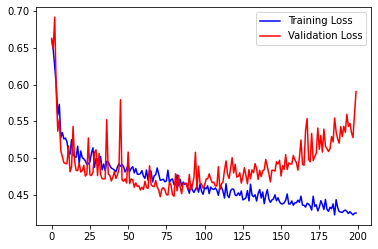

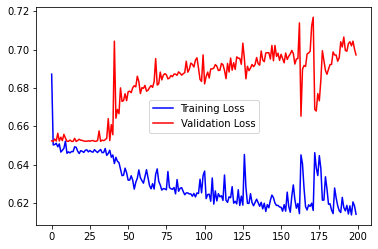

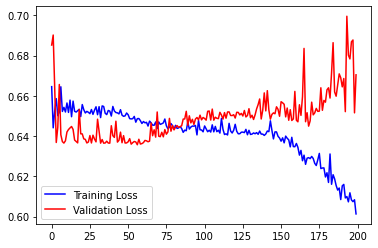

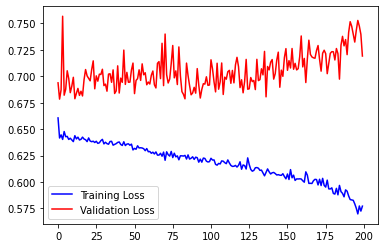

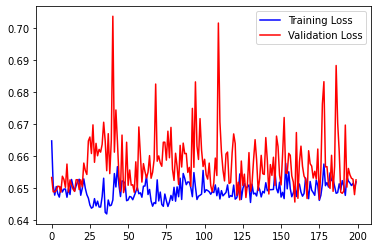

In [36]:
%%time

# model_1 = keras.models.Sequential([
#     Dense(60, activation='sigmoid', input_shape=(8,)),
#     Dense(40, activation='sigmoid'),
#     Dense(20, activation='sigmoid'),
#     # Dense(1, activation='linear')
#     Dense(2, activation='softmax')
# ])
hist, model_1 = train_kfold([60, 40, 20], 5, batch=6, lr=0.007)

<class 'dict'>
5/5 [==============================] - 0s 3ms/step - loss: 0.4493 - accuracy: 0.7914

Test accuracy: 0.7922077775001526

Test loss:  0.46417608857154846


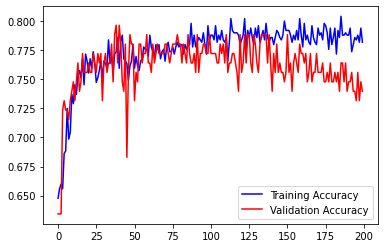

In [37]:
plt.figure(6)
print(type(hist))
plt.plot(hist['accuracy'], 'b')
plt.plot(hist['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

results = model_1.evaluate(test_fields,  test_labels_enc, return_dict=True)
print('\nTest accuracy:', results['accuracy'])
print('\nTest loss: ', results['loss'])

[[90 10]
 [22 32]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       100
           1       0.76      0.59      0.67        54

    accuracy                           0.79       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.79      0.79      0.79       154



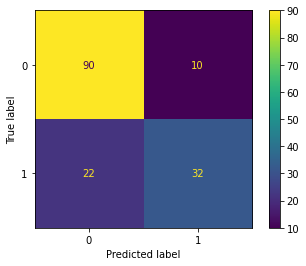

In [38]:
y_mlp = np.argmax(model_1.predict(test_fields), axis=-1)
cm_mlp = confusion_matrix(test_labels, y_mlp)
print(cm_mlp)
print(classification_report(test_labels, y_mlp, target_names= ['0', '1']))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,display_labels=['0', '1'])
disp1.plot()

### Model 2

Epoch 1/1000
164/164 [==============================] - 1s 4ms/step - loss: 0.6762 - accuracy: 0.6298 - val_loss: 0.6950 - val_accuracy: 0.6341
Epoch 2/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5841 - val_loss: 0.6665 - val_accuracy: 0.6341
Epoch 3/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6276 - val_loss: 0.6804 - val_accuracy: 0.6341
Epoch 4/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6559 - val_loss: 0.6534 - val_accuracy: 0.6341
Epoch 5/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6529 - val_loss: 0.6247 - val_accuracy: 0.6341
Epoch 6/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.5986 - accuracy: 0.6865 - val_loss: 0.5384 - val_accuracy: 0.7073
Epoch 7/1000
164/164 [==============================] - 0s 3ms/step - loss: 0.5517 - accuracy: 0.7186 - val_loss: 0.5479 - val_accuracy:

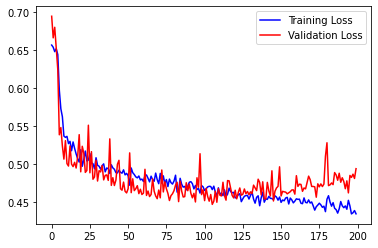

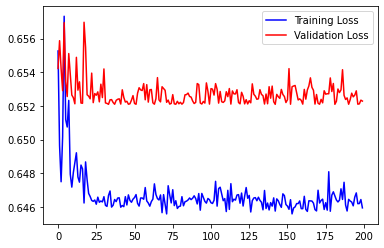

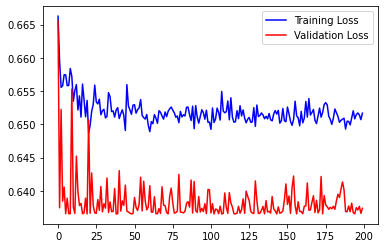

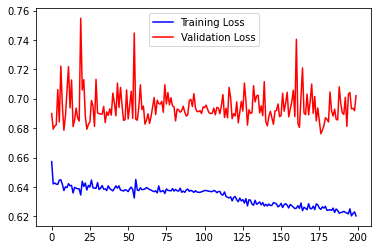

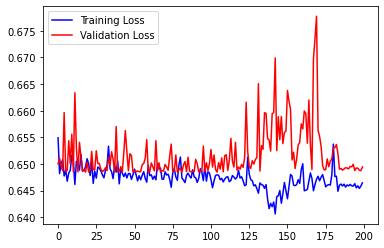

In [41]:
%%time

# model_2 = keras.models.Sequential([
#     Dense(60, activation='sigmoid', input_shape=(8,)),
#     Dense(40, activation='sigmoid'),
#     Dense(20, activation='sigmoid'),
#     # Dense(1, activation='linear')
#     Dense(2, activation='softmax')
# ])
hist_2, model_2 = train_kfold([120, 70, 40, 20], 5, batch=3, lr=0.003)

5/5 [==============================] - 0s 3ms/step - loss: 0.4566 - accuracy: 0.7996

Test accuracy: 0.8051947951316833

Test loss:  0.44319549202919006
[[84 16]
 [14 40]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       100
           1       0.71      0.74      0.73        54

    accuracy                           0.81       154
   macro avg       0.79      0.79      0.79       154
weighted avg       0.81      0.81      0.81       154



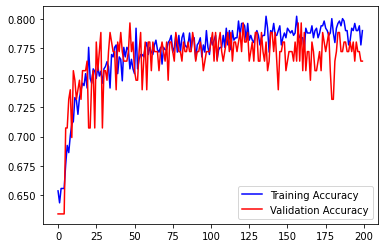

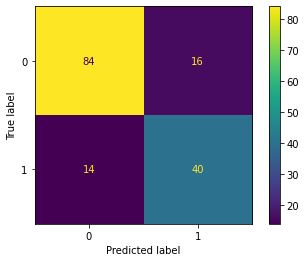

In [42]:
plt.figure(10)
plt.plot(hist_2['accuracy'], 'b')
plt.plot(hist_2['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

results = model_2.evaluate(test_fields,  test_labels_enc, return_dict=True)
print('\nTest accuracy:', results['accuracy'])
print('\nTest loss: ', results['loss'])


y_mlp = np.argmax(model_2.predict(test_fields), axis=-1)
cm_mlp = confusion_matrix(test_labels, y_mlp)
print(cm_mlp)
print(classification_report(test_labels, y_mlp, target_names= ['0', '1']))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,display_labels=['0', '1'])
disp1.plot()